In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
PATH = "drive/MyDrive/ML_Cog/ML_housing_project/"
df = pd.read_csv(PATH + "california_prices.csv")

Primary overview

In [96]:
print(df.shape)
df.head()

(18507, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,"41,0",880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,"21,0",7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.26,37.84,"42,0",2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
3,-122.26,37.85,"50,0",1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY
4,-122.26,37.84,"50,0",2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY


Check data type and NANs

In [97]:
df.info()
# TO DO in the Pipeline:
# 1) deal with NaNs --> SimpleImputer
# 2) one-hot encode the ocean_proximity categorical variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18507 entries, 0 to 18506
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18507 non-null  float64
 1   latitude            18507 non-null  float64
 2   housing_median_age  18507 non-null  object 
 3   total_rooms         18507 non-null  float64
 4   total_bedrooms      18315 non-null  float64
 5   population          18507 non-null  float64
 6   households          18507 non-null  float64
 7   median_income       18507 non-null  float64
 8   median_house_value  18507 non-null  float64
 9   ocean_proximity     18507 non-null  object 
dtypes: float64(8), object(2)
memory usage: 1.4+ MB


In [98]:
# fixing 'housing_median_age' manually, not to be treated as a string
df['housing_median_age'] = df['housing_median_age'].str.replace(",", ".").astype(float)

Look at data distibution

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

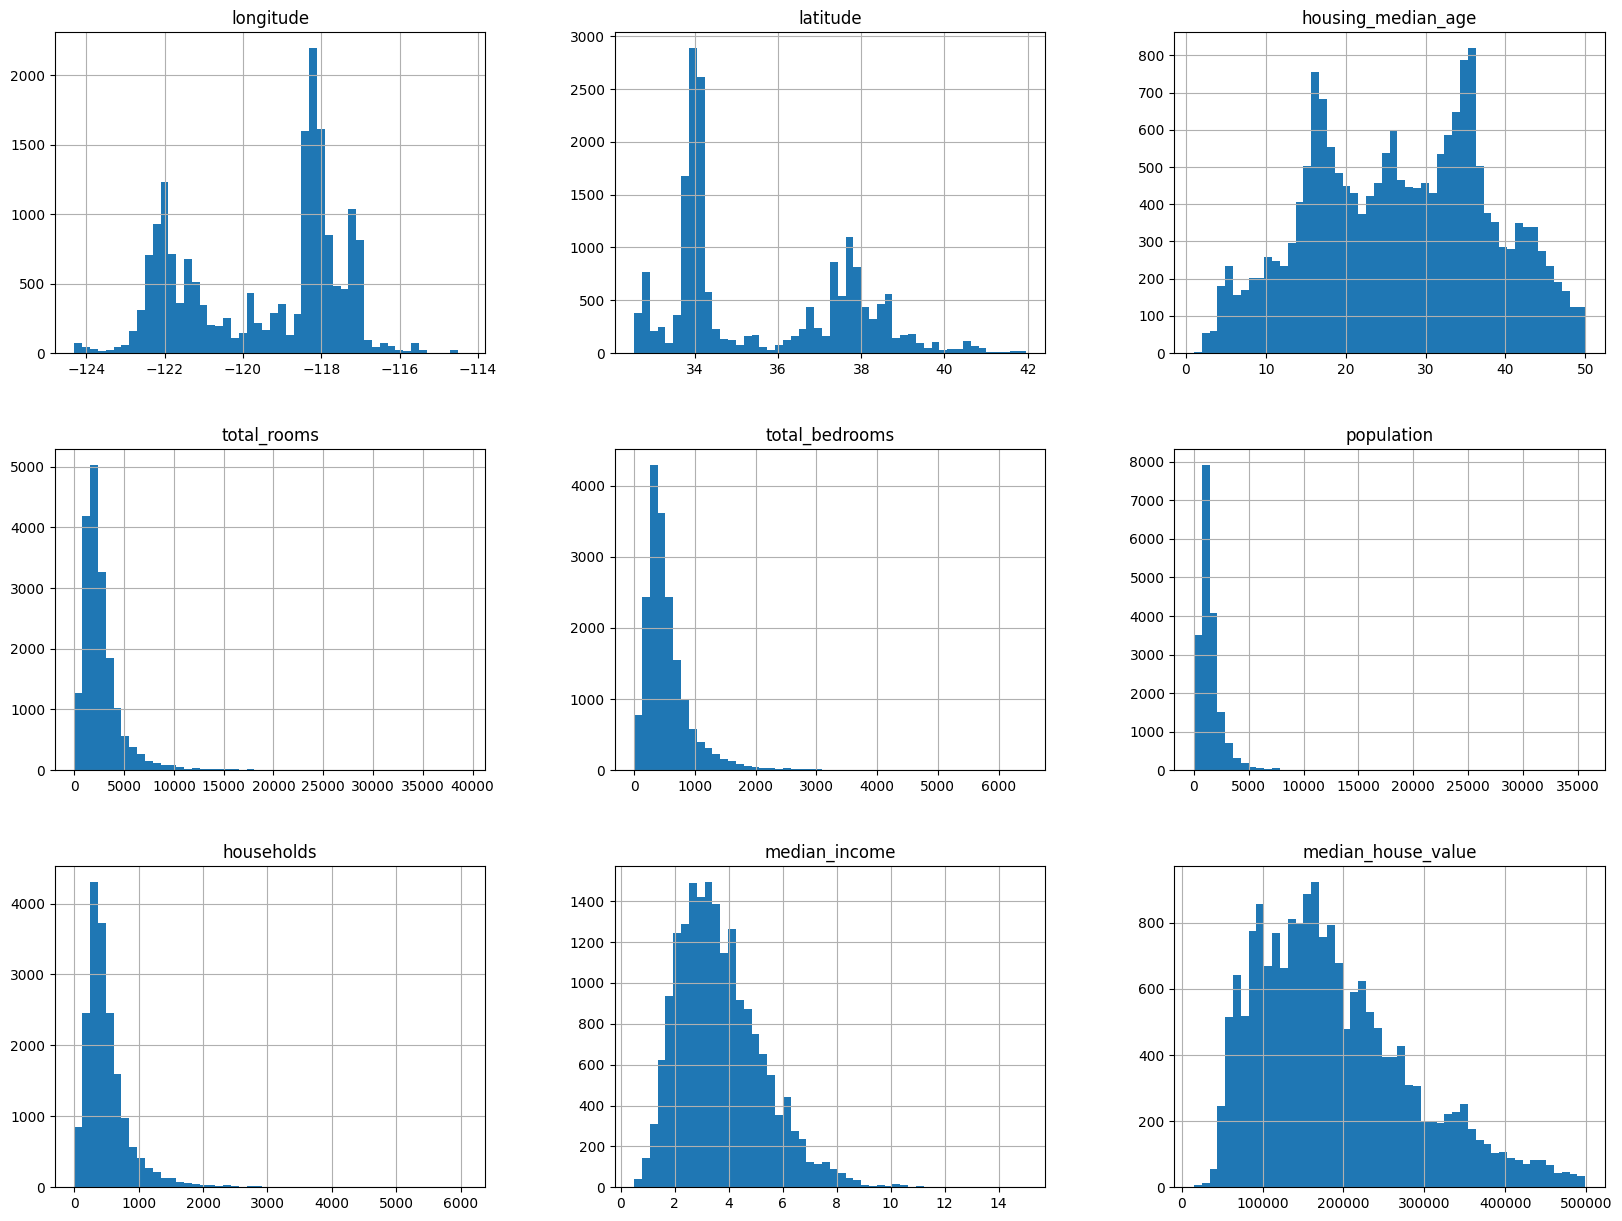

In [99]:
df.hist(bins=50, figsize=(20,15))
# as to be expected with real world data, the distributions are not normal (but mostly right-skewed here)
# perhaps more importantly, the variables have very different ranges
# TO DO in the Pipeline:
# 3) scale the data --> MinMax or Standard scaler (especially for regression later)

<Axes: >

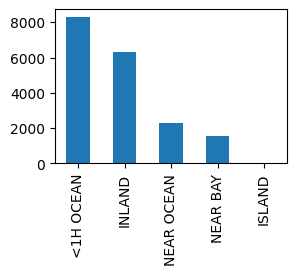

In [100]:
# for categorical variable
df['ocean_proximity'].value_counts().plot(kind='bar', figsize=(3,2))

Investigate correlations between variables

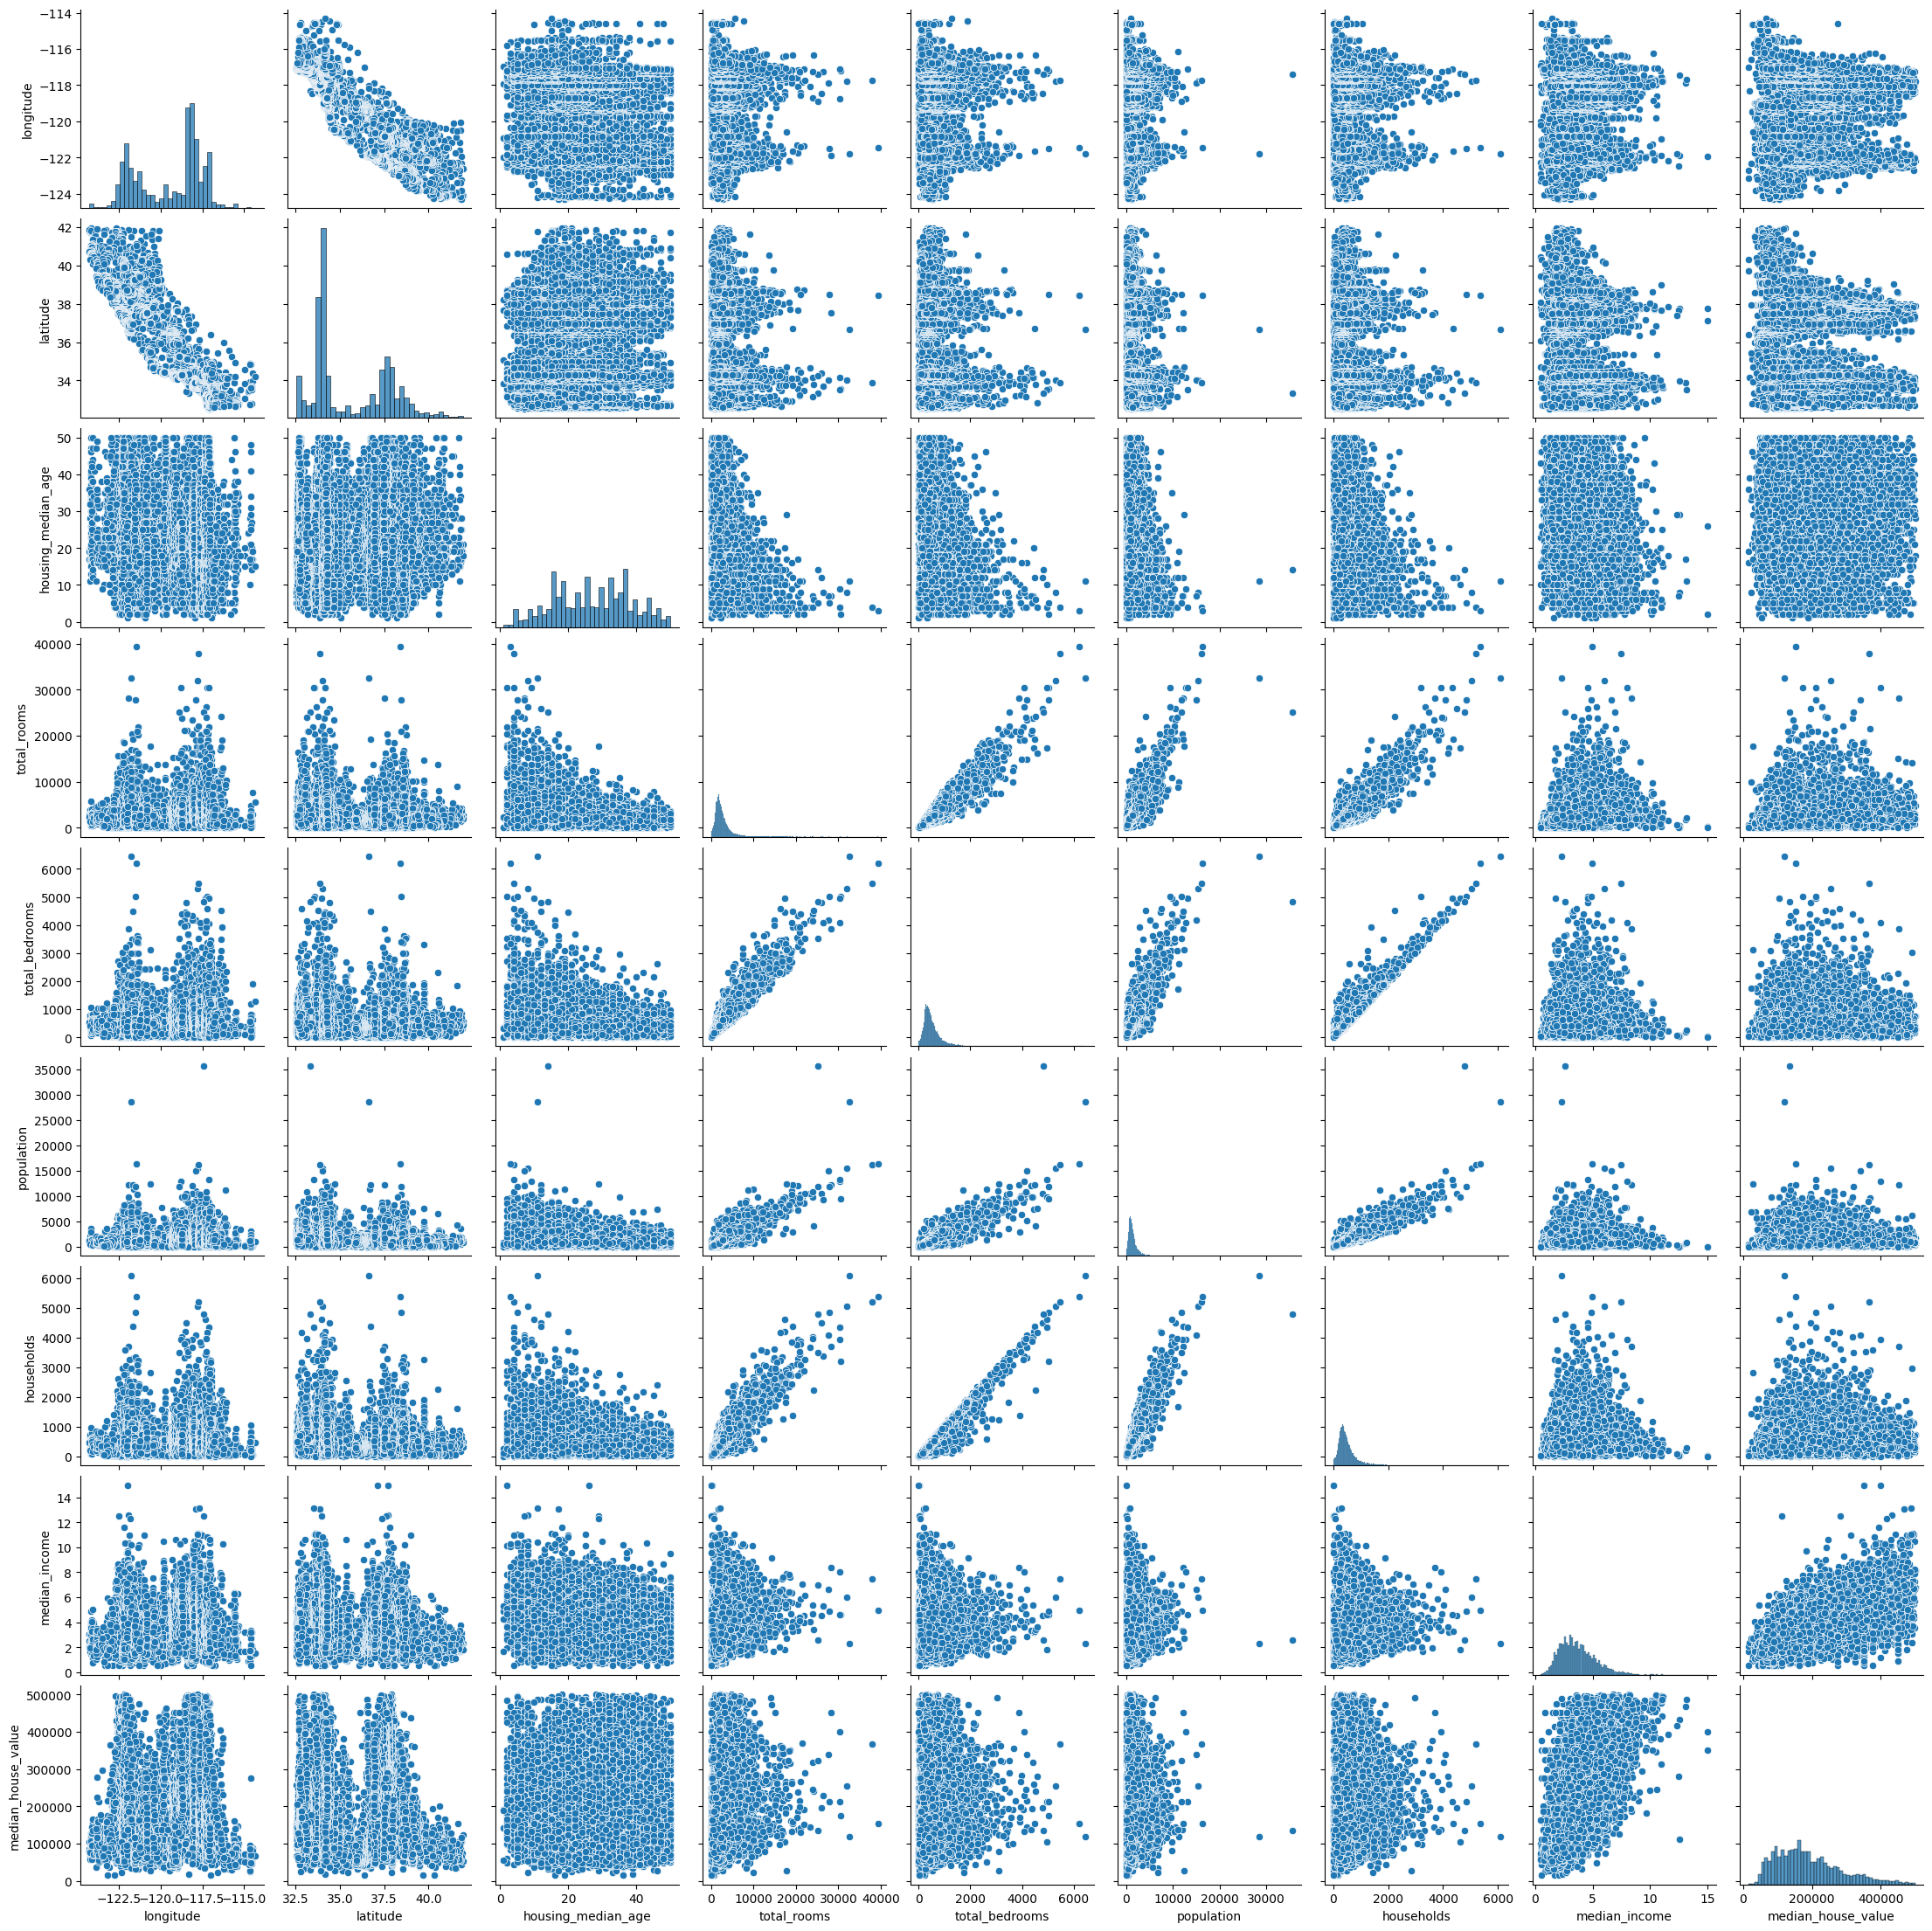

In [ ]:
sns.pairplot(df, kind='scatter')
# latitude x longitude give the shape of California; also possibly high correlations visible

In [101]:
# print 5 most correlated pairs of variables
df_cor = pd.DataFrame(df.corr(method='pearson').abs().unstack()).reset_index().sort_values(by=0, ascending=False)
df_cor.columns = ['level_0', 'level_1', 'correlation']
df_cor.drop_duplicates(subset='correlation', inplace=True)
df_cor = df_cor[df_cor.correlation != 1]
df_cor[:5]

# perhaps some new combined features would perform better
# TO DO in the Pipeline:
# 4) create new uncorrelated features
#     - rooms_per_household
#     - bedrooms_per_room
#     - population_per_household

,level_0,level_1,correlation
58,households,total_bedrooms,0.978801
39,total_bedrooms,total_rooms,0.935401
9,latitude,longitude,0.922784
33,total_rooms,households,0.921917
59,households,population,0.914237


Build the Pipeline

In [102]:
# set the target, categorical and numeric variables
target = ['median_house_value']
cat_attribs = ["ocean_proximity"]
num_attribs = df.drop(columns=['ocean_proximity', 'median_house_value']).columns.tolist()

In [103]:
class AttributeCombiner(BaseEstimator, TransformerMixin):
    rooms_idx, bedrooms_idx, population_idx, household_idx = 3, 4, 5, 6

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        rooms_per_household = X[:, self.rooms_idx] / X[:, self.household_idx]
        population_per_household = X[:, self.population_idx] / X[:, self.household_idx]
        bedrooms_per_room = X[:, self.bedrooms_idx] / X[:, self.rooms_idx]

        return np.column_stack([X, rooms_per_household, population_per_household,
                         bedrooms_per_room])

In [104]:
num_pipeline = Pipeline([
                    ('imputer', SimpleImputer(strategy="mean")),
                    ('attribs_adder', AttributeCombiner()),
                    ('scaler', StandardScaler())])

cat_pipeline = Pipeline([
                    ('onehot_encoder', OneHotEncoder(sparse=False))]) # the 1st column will be dropped later

data_pipeline = ColumnTransformer(transformers=[('num', num_pipeline, num_attribs),
                                                ('cat', cat_pipeline, cat_attribs)],
                                  remainder='passthrough')

set_config(display='diagram')
data_pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('attribs_adder',
                                                  AttributeCombiner()),
                                                 ('scaler', StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat',
                                 Pipeline(steps=[('onehot_encoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['ocean_proximity'])])

In [105]:
transformed_df = data_pipeline.fit_transform(df)

In [106]:
col_names = ['longitude', 'latitude', 'housing_median_age','total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'population_per_household', 'bedrooms_per_room',
       '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'median_house_value']

transformed_df = pd.DataFrame(transformed_df)
transformed_df.columns=col_names

In [107]:
transformed_df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-1.386978,1.065123,1.236409,-0.804863,-0.980912,-0.989134,-0.982482,2.949934,0.681600,-0.402669,-1.066757,0.0,0.0,0.0,1.0,0.0,452600.0
1,-1.381929,1.055812,-0.520215,1.988664,1.303914,0.800926,1.612750,2.934773,0.362831,-0.825340,-0.923822,0.0,0.0,0.0,1.0,0.0,358500.0
2,-1.402124,1.046501,1.324240,-0.052466,0.272585,-0.227993,0.220249,-1.028035,-0.467868,-0.904003,0.698387,0.0,0.0,0.0,1.0,0.0,226700.0
3,-1.402124,1.051157,2.026889,-0.697057,-0.620766,-0.666252,-0.628587,-0.999624,-0.489957,-0.322446,0.580454,0.0,0.0,0.0,1.0,0.0,140000.0
4,-1.402124,1.046501,2.026889,-0.194411,-0.218524,-0.413973,-0.231096,-1.084919,-0.019382,-0.585489,-0.187550,0.0,0.0,0.0,1.0,0.0,158700.0
5,-1.407173,1.051157,1.148577,-0.862809,-0.852288,-0.914226,-0.879904,-1.488334,-0.369596,-0.489628,0.461333,0.0,0.0,0.0,1.0,0.0,147500.0
6,-1.407173,1.051157,1.324240,-0.463927,-0.424322,-0.466495,-0.367012,-1.261752,-0.389233,-0.419078,0.133876,0.0,0.0,0.0,1.0,0.0,159800.0
7,-1.412222,1.051157,1.236409,-0.959835,-0.994944,-0.993439,-1.000434,-0.822027,-0.381688,-0.299958,0.226875,0.0,0.0,0.0,1.0,0.0,107500.0
8,-1.412222,1.051157,1.939058,-0.692565,-0.711972,-0.743744,-0.692698,-0.786419,-0.282452,-0.417658,0.009851,0.0,0.0,0.0,1.0,0.0,93800.0
9,-1.412222,1.046501,2.026889,-0.264934,-0.131995,-0.292569,-0.092615,-1.307043,-0.421901,-0.558603,0.326320,0.0,0.0,0.0,1.0,0.0,108900.0


In [108]:
# split the data
train, test = train_test_split(transformed_df, test_size=0.2, random_state=42)

In [109]:
# save the data ready for lin reg model
train.to_csv(r"housing_train.csv")
test.to_csv(r"housing_test.csv")